# GANs for Jeans

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dir = '../input/men-jeans'
print(os.listdir(dir))

['Mens_Jeans']


In [4]:
##printing first 20 image names
print(os.listdir(dir+'/Mens_Jeans')[:20])

['Men_Jeans1519.png', 'Men_Jeans1313.png', 'Men_Jeans1288.png', 'Men_Jeans1408.png', 'Men_Jeans1573.png', 'Men_Jeans1409.png', 'Men_Jeans138.png', 'Men_Jeans1181.png', 'Men_Jeans1162.png', 'Men_Jeans1137.png', 'Men_Jeans108.png', 'Men_Jeans1141.png', 'Men_Jeans1577.png', 'Men_Jeans1659.png', 'Men_Jeans1028.png', 'Men_Jeans1674.png', 'Men_Jeans1557.png', 'Men_Jeans1474.png', 'Men_Jeans1131.png', 'Men_Jeans1281.png']


In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(dir, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

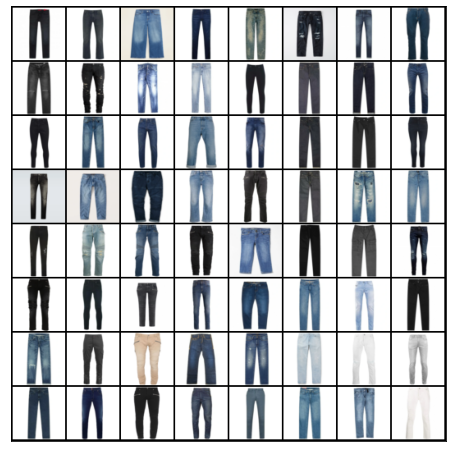

In [8]:
show_batch(train_dl)

In [9]:
def is_cuda_available():
    if torch.cuda.is_available():
        print("CUDA available. Training on GPU!")
        return torch.device('cuda')
    else:
        print("CUDA not available. Training on CPU!")
        return torch.device('cpu')


In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
is_cuda_available()

CUDA available. Training on GPU!


device(type='cuda')

In [12]:
device=is_cuda_available()
train_dl = DeviceDataLoader(train_dl, device)

CUDA available. Training on GPU!


In [13]:
#basic cnn with convolutional layers and leaky relu as activation fn
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


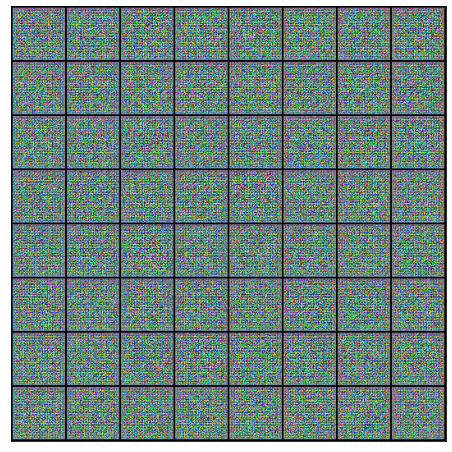

In [16]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [17]:
generator = to_device(generator, device)

In [18]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [19]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()


In [20]:

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [21]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [22]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


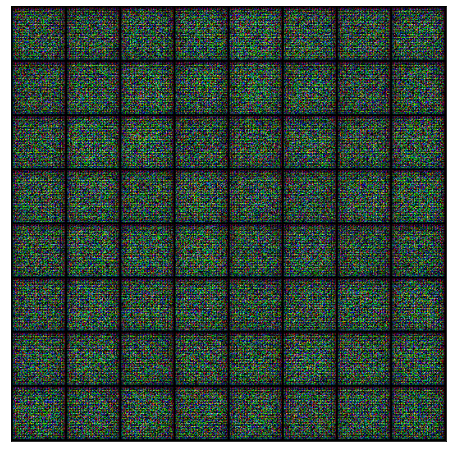

In [23]:
save_samples(0, fixed_latent)

In [24]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0003
epochs = 200

In [34]:
history=fit(epochs,lr)


Epoch [1/200], loss_g: 0.9787, loss_d: 0.8832, real_score: 0.6337, fake_score: 0.3184
Saving generated-images-0001.png



Epoch [2/200], loss_g: 0.8762, loss_d: 1.1122, real_score: 0.4071, fake_score: 0.1344
Saving generated-images-0002.png



Epoch [3/200], loss_g: 2.2861, loss_d: 0.6900, real_score: 0.7796, fake_score: 0.3428
Saving generated-images-0003.png



Epoch [4/200], loss_g: 2.0881, loss_d: 0.9989, real_score: 0.6752, fake_score: 0.4175
Saving generated-images-0004.png



Epoch [5/200], loss_g: 1.4517, loss_d: 0.9155, real_score: 0.5480, fake_score: 0.2102
Saving generated-images-0005.png



Epoch [6/200], loss_g: 2.1478, loss_d: 0.8330, real_score: 0.7834, fake_score: 0.4221
Saving generated-images-0006.png



Epoch [7/200], loss_g: 1.5436, loss_d: 1.1221, real_score: 0.6472, fake_score: 0.4556
Saving generated-images-0007.png



Epoch [8/200], loss_g: 0.4371, loss_d: 1.7598, real_score: 0.2239, fake_score: 0.0844
Saving generated-images-0008.png



Epoch [9/200], loss_g: 0.7918, loss_d: 1.5036, real_score: 0.3853, fake_score: 0.3673
Saving generated-images-0009.png



Epoch [10/200], loss_g: 1.6259, loss_d: 0.8860, real_score: 0.6686, fake_score: 0.3550
Saving generated-images-0010.png



Epoch [11/200], loss_g: 0.6739, loss_d: 2.4360, real_score: 0.1187, fake_score: 0.0449
Saving generated-images-0011.png



Epoch [12/200], loss_g: 1.8320, loss_d: 0.7889, real_score: 0.7569, fake_score: 0.3754
Saving generated-images-0012.png



Epoch [13/200], loss_g: 3.0023, loss_d: 1.2384, real_score: 0.8965, fake_score: 0.6486
Saving generated-images-0013.png



Epoch [14/200], loss_g: 1.1612, loss_d: 0.9973, real_score: 0.5988, fake_score: 0.3397
Saving generated-images-0014.png



Epoch [15/200], loss_g: 1.4435, loss_d: 1.1243, real_score: 0.7038, fake_score: 0.4991
Saving generated-images-0015.png



Epoch [16/200], loss_g: 3.0174, loss_d: 0.8797, real_score: 0.8052, fake_score: 0.4539
Saving generated-images-0016.png



Epoch [17/200], loss_g: 1.6370, loss_d: 0.9875, real_score: 0.7285, fake_score: 0.4328
Saving generated-images-0017.png



Epoch [18/200], loss_g: 2.1938, loss_d: 1.5109, real_score: 0.8686, fake_score: 0.7014
Saving generated-images-0018.png



Epoch [19/200], loss_g: 1.0538, loss_d: 1.1932, real_score: 0.4322, fake_score: 0.2511
Saving generated-images-0019.png



Epoch [20/200], loss_g: 1.7090, loss_d: 1.0176, real_score: 0.7641, fake_score: 0.4997
Saving generated-images-0020.png



Epoch [21/200], loss_g: 1.0136, loss_d: 1.1847, real_score: 0.4779, fake_score: 0.3159
Saving generated-images-0021.png



Epoch [22/200], loss_g: 0.8762, loss_d: 1.0789, real_score: 0.5145, fake_score: 0.2946
Saving generated-images-0022.png



Epoch [23/200], loss_g: 1.7904, loss_d: 0.7106, real_score: 0.6996, fake_score: 0.2685
Saving generated-images-0023.png



Epoch [24/200], loss_g: 1.1281, loss_d: 1.0614, real_score: 0.4828, fake_score: 0.2396
Saving generated-images-0024.png



Epoch [25/200], loss_g: 1.3817, loss_d: 0.8875, real_score: 0.5392, fake_score: 0.1994
Saving generated-images-0025.png



Epoch [26/200], loss_g: 1.6195, loss_d: 1.0689, real_score: 0.4436, fake_score: 0.0996
Saving generated-images-0026.png



Epoch [27/200], loss_g: 2.3428, loss_d: 1.1779, real_score: 0.8251, fake_score: 0.5742
Saving generated-images-0027.png



Epoch [28/200], loss_g: 1.6920, loss_d: 1.0035, real_score: 0.8006, fake_score: 0.5097
Saving generated-images-0028.png



Epoch [29/200], loss_g: 1.6559, loss_d: 0.7930, real_score: 0.6212, fake_score: 0.2252
Saving generated-images-0029.png



Epoch [30/200], loss_g: 2.2486, loss_d: 1.0550, real_score: 0.8096, fake_score: 0.5385
Saving generated-images-0030.png



Epoch [31/200], loss_g: 2.7535, loss_d: 1.1975, real_score: 0.8715, fake_score: 0.6175
Saving generated-images-0031.png



Epoch [32/200], loss_g: 2.2027, loss_d: 0.5583, real_score: 0.7732, fake_score: 0.2393
Saving generated-images-0032.png



Epoch [33/200], loss_g: 2.0366, loss_d: 1.4283, real_score: 0.6819, fake_score: 0.6062
Saving generated-images-0033.png



Epoch [34/200], loss_g: 1.6049, loss_d: 1.1311, real_score: 0.5613, fake_score: 0.3881
Saving generated-images-0034.png



Epoch [35/200], loss_g: 0.8201, loss_d: 1.3212, real_score: 0.4449, fake_score: 0.3450
Saving generated-images-0035.png



Epoch [36/200], loss_g: 1.1236, loss_d: 1.0565, real_score: 0.4437, fake_score: 0.1501
Saving generated-images-0036.png



Epoch [37/200], loss_g: 1.7223, loss_d: 0.8958, real_score: 0.6350, fake_score: 0.3095
Saving generated-images-0037.png



Epoch [38/200], loss_g: 3.9700, loss_d: 0.9154, real_score: 0.9088, fake_score: 0.5236
Saving generated-images-0038.png



Epoch [39/200], loss_g: 2.1233, loss_d: 1.3098, real_score: 0.7603, fake_score: 0.6219
Saving generated-images-0039.png



Epoch [40/200], loss_g: 1.7545, loss_d: 0.7076, real_score: 0.7398, fake_score: 0.3130
Saving generated-images-0040.png



Epoch [41/200], loss_g: 3.2871, loss_d: 1.0892, real_score: 0.8445, fake_score: 0.5715
Saving generated-images-0041.png



Epoch [42/200], loss_g: 1.6900, loss_d: 0.7100, real_score: 0.6085, fake_score: 0.1711
Saving generated-images-0042.png



Epoch [43/200], loss_g: 0.5336, loss_d: 1.3578, real_score: 0.3378, fake_score: 0.1338
Saving generated-images-0043.png



Epoch [44/200], loss_g: 1.7178, loss_d: 0.9374, real_score: 0.5519, fake_score: 0.2283
Saving generated-images-0044.png



Epoch [45/200], loss_g: 1.4973, loss_d: 1.1244, real_score: 0.5901, fake_score: 0.4141
Saving generated-images-0045.png



Epoch [46/200], loss_g: 3.1280, loss_d: 0.8545, real_score: 0.8442, fake_score: 0.4632
Saving generated-images-0046.png



Epoch [47/200], loss_g: 1.7276, loss_d: 0.8384, real_score: 0.7185, fake_score: 0.3673
Saving generated-images-0047.png



Epoch [48/200], loss_g: 0.9774, loss_d: 1.3323, real_score: 0.3715, fake_score: 0.2194
Saving generated-images-0048.png



Epoch [49/200], loss_g: 2.1159, loss_d: 0.8210, real_score: 0.7753, fake_score: 0.4080
Saving generated-images-0049.png



Epoch [50/200], loss_g: 1.6889, loss_d: 0.8494, real_score: 0.6424, fake_score: 0.2929
Saving generated-images-0050.png



Epoch [51/200], loss_g: 1.9628, loss_d: 0.8719, real_score: 0.6593, fake_score: 0.3381
Saving generated-images-0051.png



Epoch [52/200], loss_g: 1.4189, loss_d: 0.8349, real_score: 0.5932, fake_score: 0.2085
Saving generated-images-0052.png



Epoch [53/200], loss_g: 2.1287, loss_d: 0.8803, real_score: 0.7087, fake_score: 0.3664
Saving generated-images-0053.png



Epoch [54/200], loss_g: 0.5196, loss_d: 2.1858, real_score: 0.1875, fake_score: 0.0456
Saving generated-images-0054.png



Epoch [55/200], loss_g: 1.8344, loss_d: 1.0974, real_score: 0.7318, fake_score: 0.5071
Saving generated-images-0055.png



Epoch [56/200], loss_g: 1.5538, loss_d: 0.7737, real_score: 0.5950, fake_score: 0.1859
Saving generated-images-0056.png



Epoch [57/200], loss_g: 0.7776, loss_d: 0.6707, real_score: 0.7144, fake_score: 0.2603
Saving generated-images-0057.png



Epoch [58/200], loss_g: 1.6976, loss_d: 0.7292, real_score: 0.6645, fake_score: 0.2407
Saving generated-images-0058.png



Epoch [59/200], loss_g: 0.7014, loss_d: 2.1388, real_score: 0.1820, fake_score: 0.0755
Saving generated-images-0059.png



Epoch [60/200], loss_g: 0.6907, loss_d: 1.3037, real_score: 0.4359, fake_score: 0.3098
Saving generated-images-0060.png



Epoch [61/200], loss_g: 0.8232, loss_d: 1.0595, real_score: 0.5307, fake_score: 0.2930
Saving generated-images-0061.png



Epoch [62/200], loss_g: 1.7157, loss_d: 0.7853, real_score: 0.6429, fake_score: 0.2665
Saving generated-images-0062.png



Epoch [63/200], loss_g: 2.4902, loss_d: 0.8386, real_score: 0.7931, fake_score: 0.4271
Saving generated-images-0063.png



Epoch [64/200], loss_g: 1.3264, loss_d: 0.8710, real_score: 0.5064, fake_score: 0.1273
Saving generated-images-0064.png



Epoch [65/200], loss_g: 4.1150, loss_d: 1.2340, real_score: 0.9487, fake_score: 0.6485
Saving generated-images-0065.png



Epoch [66/200], loss_g: 1.7263, loss_d: 1.0833, real_score: 0.7571, fake_score: 0.5217
Saving generated-images-0066.png



Epoch [67/200], loss_g: 2.1148, loss_d: 0.9620, real_score: 0.8005, fake_score: 0.4794
Saving generated-images-0067.png



Epoch [68/200], loss_g: 0.7969, loss_d: 1.6198, real_score: 0.2257, fake_score: 0.0790
Saving generated-images-0068.png



Epoch [69/200], loss_g: 1.0824, loss_d: 1.0037, real_score: 0.4951, fake_score: 0.2073
Saving generated-images-0069.png



Epoch [70/200], loss_g: 1.9988, loss_d: 0.7349, real_score: 0.6456, fake_score: 0.2127
Saving generated-images-0070.png



Epoch [71/200], loss_g: 3.0918, loss_d: 0.8270, real_score: 0.8248, fake_score: 0.4465
Saving generated-images-0071.png



Epoch [72/200], loss_g: 1.7803, loss_d: 0.8166, real_score: 0.7233, fake_score: 0.3542
Saving generated-images-0072.png



Epoch [73/200], loss_g: 1.4500, loss_d: 0.9984, real_score: 0.6535, fake_score: 0.3878
Saving generated-images-0073.png



Epoch [74/200], loss_g: 1.0359, loss_d: 1.1485, real_score: 0.3915, fake_score: 0.1117
Saving generated-images-0074.png



Epoch [75/200], loss_g: 0.9215, loss_d: 0.8930, real_score: 0.5227, fake_score: 0.1566
Saving generated-images-0075.png



Epoch [76/200], loss_g: 2.9056, loss_d: 0.8841, real_score: 0.9311, fake_score: 0.5227
Saving generated-images-0076.png



Epoch [77/200], loss_g: 1.7872, loss_d: 0.5956, real_score: 0.7060, fake_score: 0.1933
Saving generated-images-0077.png



Epoch [78/200], loss_g: 1.7775, loss_d: 0.8327, real_score: 0.6640, fake_score: 0.2990
Saving generated-images-0078.png



Epoch [79/200], loss_g: 2.2591, loss_d: 0.6302, real_score: 0.7426, fake_score: 0.2542
Saving generated-images-0079.png



Epoch [80/200], loss_g: 2.9808, loss_d: 0.5474, real_score: 0.8804, fake_score: 0.3211
Saving generated-images-0080.png



Epoch [81/200], loss_g: 2.6460, loss_d: 0.7047, real_score: 0.8338, fake_score: 0.3851
Saving generated-images-0081.png



Epoch [82/200], loss_g: 2.7101, loss_d: 0.6928, real_score: 0.8475, fake_score: 0.3785
Saving generated-images-0082.png



Epoch [83/200], loss_g: 1.8095, loss_d: 0.8971, real_score: 0.7683, fake_score: 0.4302
Saving generated-images-0083.png



Epoch [84/200], loss_g: 1.2352, loss_d: 0.8510, real_score: 0.5630, fake_score: 0.1832
Saving generated-images-0084.png



Epoch [85/200], loss_g: 1.4276, loss_d: 0.9852, real_score: 0.6221, fake_score: 0.3740
Saving generated-images-0085.png



Epoch [86/200], loss_g: 1.0988, loss_d: 1.2353, real_score: 0.3689, fake_score: 0.1576
Saving generated-images-0086.png



Epoch [87/200], loss_g: 1.1469, loss_d: 1.0608, real_score: 0.4463, fake_score: 0.1282
Saving generated-images-0087.png



Epoch [88/200], loss_g: 2.7680, loss_d: 0.6520, real_score: 0.8089, fake_score: 0.3314
Saving generated-images-0088.png



Epoch [89/200], loss_g: 1.9140, loss_d: 0.8925, real_score: 0.7602, fake_score: 0.4186
Saving generated-images-0089.png



Epoch [90/200], loss_g: 0.6062, loss_d: 0.7831, real_score: 0.5656, fake_score: 0.1566
Saving generated-images-0090.png



Epoch [91/200], loss_g: 0.8893, loss_d: 1.7852, real_score: 0.2372, fake_score: 0.0896
Saving generated-images-0091.png



Epoch [92/200], loss_g: 0.8019, loss_d: 1.2184, real_score: 0.4185, fake_score: 0.2215
Saving generated-images-0092.png



Epoch [93/200], loss_g: 1.9962, loss_d: 0.8712, real_score: 0.7439, fake_score: 0.4093
Saving generated-images-0093.png



Epoch [94/200], loss_g: 1.0551, loss_d: 1.2546, real_score: 0.3388, fake_score: 0.0992
Saving generated-images-0094.png



Epoch [95/200], loss_g: 1.9255, loss_d: 0.7097, real_score: 0.6408, fake_score: 0.1989
Saving generated-images-0095.png



Epoch [96/200], loss_g: 1.3408, loss_d: 0.8360, real_score: 0.5785, fake_score: 0.2221
Saving generated-images-0096.png



Epoch [97/200], loss_g: 1.2583, loss_d: 0.6204, real_score: 0.6708, fake_score: 0.1508
Saving generated-images-0097.png



Epoch [98/200], loss_g: 1.3969, loss_d: 0.7952, real_score: 0.7307, fake_score: 0.3407
Saving generated-images-0098.png



Epoch [99/200], loss_g: 2.8936, loss_d: 0.6238, real_score: 0.8237, fake_score: 0.3286
Saving generated-images-0099.png



Epoch [100/200], loss_g: 2.6368, loss_d: 0.5232, real_score: 0.9181, fake_score: 0.3324
Saving generated-images-0100.png



Epoch [101/200], loss_g: 1.3040, loss_d: 0.7054, real_score: 0.6066, fake_score: 0.1441
Saving generated-images-0101.png



Epoch [102/200], loss_g: 0.8854, loss_d: 1.6865, real_score: 0.2460, fake_score: 0.0902
Saving generated-images-0102.png



Epoch [103/200], loss_g: 0.8157, loss_d: 1.2280, real_score: 0.3755, fake_score: 0.1477
Saving generated-images-0103.png



Epoch [104/200], loss_g: 0.9316, loss_d: 0.9796, real_score: 0.4466, fake_score: 0.1138
Saving generated-images-0104.png



Epoch [105/200], loss_g: 1.4997, loss_d: 0.6813, real_score: 0.6640, fake_score: 0.1926
Saving generated-images-0105.png



Epoch [106/200], loss_g: 2.5685, loss_d: 0.7823, real_score: 0.9133, fake_score: 0.4738
Saving generated-images-0106.png



Epoch [107/200], loss_g: 1.0505, loss_d: 0.9343, real_score: 0.5476, fake_score: 0.2308
Saving generated-images-0107.png



Epoch [108/200], loss_g: 2.0606, loss_d: 0.8052, real_score: 0.7866, fake_score: 0.3897
Saving generated-images-0108.png



Epoch [109/200], loss_g: 2.2574, loss_d: 0.6421, real_score: 0.7318, fake_score: 0.2435
Saving generated-images-0109.png



Epoch [110/200], loss_g: 1.1864, loss_d: 0.8789, real_score: 0.5728, fake_score: 0.2407
Saving generated-images-0110.png



Epoch [111/200], loss_g: 1.8571, loss_d: 0.5446, real_score: 0.7526, fake_score: 0.2039
Saving generated-images-0111.png



Epoch [112/200], loss_g: 2.8927, loss_d: 0.4328, real_score: 0.8502, fake_score: 0.2192
Saving generated-images-0112.png



Epoch [113/200], loss_g: 1.7538, loss_d: 1.7575, real_score: 0.2334, fake_score: 0.0066
Saving generated-images-0113.png



Epoch [114/200], loss_g: 1.9853, loss_d: 0.8497, real_score: 0.6548, fake_score: 0.2894
Saving generated-images-0114.png



Epoch [115/200], loss_g: 1.0150, loss_d: 1.1610, real_score: 0.4529, fake_score: 0.2495
Saving generated-images-0115.png



Epoch [116/200], loss_g: 2.0150, loss_d: 0.6796, real_score: 0.7625, fake_score: 0.3129
Saving generated-images-0116.png



Epoch [117/200], loss_g: 1.5227, loss_d: 0.8127, real_score: 0.6397, fake_score: 0.2420
Saving generated-images-0117.png



Epoch [118/200], loss_g: 1.5622, loss_d: 0.7443, real_score: 0.6604, fake_score: 0.2366
Saving generated-images-0118.png



Epoch [119/200], loss_g: 1.9767, loss_d: 0.6999, real_score: 0.5738, fake_score: 0.0823
Saving generated-images-0119.png



Epoch [120/200], loss_g: 1.9474, loss_d: 0.6253, real_score: 0.7295, fake_score: 0.2051
Saving generated-images-0120.png



Epoch [121/200], loss_g: 2.6097, loss_d: 0.6100, real_score: 0.9119, fake_score: 0.3772
Saving generated-images-0121.png



Epoch [122/200], loss_g: 2.2524, loss_d: 0.2985, real_score: 0.9226, fake_score: 0.1854
Saving generated-images-0122.png



Epoch [123/200], loss_g: 3.4537, loss_d: 1.2090, real_score: 0.9481, fake_score: 0.6377
Saving generated-images-0123.png



Epoch [124/200], loss_g: 2.1268, loss_d: 0.6536, real_score: 0.7824, fake_score: 0.3024
Saving generated-images-0124.png



Epoch [125/200], loss_g: 1.6109, loss_d: 0.4729, real_score: 0.7470, fake_score: 0.1459
Saving generated-images-0125.png



Epoch [126/200], loss_g: 3.1221, loss_d: 1.2746, real_score: 0.9547, fake_score: 0.6391
Saving generated-images-0126.png



Epoch [127/200], loss_g: 2.8219, loss_d: 0.6721, real_score: 0.8802, fake_score: 0.3714
Saving generated-images-0127.png



Epoch [128/200], loss_g: 3.2487, loss_d: 0.4861, real_score: 0.8763, fake_score: 0.2676
Saving generated-images-0128.png



Epoch [129/200], loss_g: 2.2106, loss_d: 0.6558, real_score: 0.6162, fake_score: 0.1055
Saving generated-images-0129.png



Epoch [130/200], loss_g: 2.0737, loss_d: 0.7378, real_score: 0.8619, fake_score: 0.4039
Saving generated-images-0130.png



Epoch [131/200], loss_g: 1.2612, loss_d: 0.6049, real_score: 0.6913, fake_score: 0.1749
Saving generated-images-0131.png



Epoch [132/200], loss_g: 2.2619, loss_d: 0.3099, real_score: 0.8592, fake_score: 0.1358
Saving generated-images-0132.png



Epoch [133/200], loss_g: 1.9403, loss_d: 0.3604, real_score: 0.7656, fake_score: 0.0682
Saving generated-images-0133.png



Epoch [134/200], loss_g: 4.7840, loss_d: 1.0277, real_score: 0.9087, fake_score: 0.5518
Saving generated-images-0134.png



Epoch [135/200], loss_g: 2.6370, loss_d: 0.7210, real_score: 0.8270, fake_score: 0.3657
Saving generated-images-0135.png



Epoch [136/200], loss_g: 1.7682, loss_d: 0.8550, real_score: 0.6973, fake_score: 0.3581
Saving generated-images-0136.png



Epoch [137/200], loss_g: 2.0192, loss_d: 0.4403, real_score: 0.6927, fake_score: 0.0494
Saving generated-images-0137.png



Epoch [138/200], loss_g: 0.5759, loss_d: 2.4801, real_score: 0.1052, fake_score: 0.0462
Saving generated-images-0138.png



Epoch [139/200], loss_g: 1.3117, loss_d: 1.1852, real_score: 0.4365, fake_score: 0.2587
Saving generated-images-0139.png



Epoch [140/200], loss_g: 3.1126, loss_d: 0.5257, real_score: 0.8897, fake_score: 0.3158
Saving generated-images-0140.png



Epoch [141/200], loss_g: 1.6003, loss_d: 0.7844, real_score: 0.5691, fake_score: 0.1436
Saving generated-images-0141.png



Epoch [142/200], loss_g: 2.1179, loss_d: 0.4643, real_score: 0.7957, fake_score: 0.1930
Saving generated-images-0142.png



Epoch [143/200], loss_g: 2.5645, loss_d: 0.3948, real_score: 0.7552, fake_score: 0.0870
Saving generated-images-0143.png



Epoch [144/200], loss_g: 2.6121, loss_d: 0.4006, real_score: 0.9013, fake_score: 0.2379
Saving generated-images-0144.png



Epoch [145/200], loss_g: 2.1467, loss_d: 0.3982, real_score: 0.8061, fake_score: 0.1519
Saving generated-images-0145.png



Epoch [146/200], loss_g: 0.2597, loss_d: 1.9885, real_score: 0.1772, fake_score: 0.0646
Saving generated-images-0146.png



Epoch [147/200], loss_g: 2.3601, loss_d: 0.6781, real_score: 0.6584, fake_score: 0.1791
Saving generated-images-0147.png



Epoch [148/200], loss_g: 0.9929, loss_d: 0.8924, real_score: 0.5499, fake_score: 0.2064
Saving generated-images-0148.png



Epoch [149/200], loss_g: 1.5641, loss_d: 0.7637, real_score: 0.6800, fake_score: 0.2787
Saving generated-images-0149.png



Epoch [150/200], loss_g: 2.1264, loss_d: 0.6009, real_score: 0.8050, fake_score: 0.2927
Saving generated-images-0150.png



Epoch [151/200], loss_g: 0.9950, loss_d: 0.8201, real_score: 0.5153, fake_score: 0.0562
Saving generated-images-0151.png



Epoch [152/200], loss_g: 2.2792, loss_d: 0.5337, real_score: 0.8378, fake_score: 0.2581
Saving generated-images-0152.png



Epoch [153/200], loss_g: 2.2705, loss_d: 0.7027, real_score: 0.6044, fake_score: 0.1423
Saving generated-images-0153.png



Epoch [154/200], loss_g: 0.5751, loss_d: 1.5506, real_score: 0.3131, fake_score: 0.1533
Saving generated-images-0154.png



Epoch [155/200], loss_g: 1.8819, loss_d: 0.7256, real_score: 0.5732, fake_score: 0.0834
Saving generated-images-0155.png



Epoch [156/200], loss_g: 3.1235, loss_d: 0.6062, real_score: 0.8960, fake_score: 0.3576
Saving generated-images-0156.png



Epoch [157/200], loss_g: 3.2687, loss_d: 0.2950, real_score: 0.8687, fake_score: 0.1315
Saving generated-images-0157.png



Epoch [158/200], loss_g: 1.6433, loss_d: 0.5233, real_score: 0.6974, fake_score: 0.1281
Saving generated-images-0158.png



Epoch [159/200], loss_g: 2.9324, loss_d: 0.1697, real_score: 0.9275, fake_score: 0.0857
Saving generated-images-0159.png



Epoch [160/200], loss_g: 4.0533, loss_d: 0.4736, real_score: 0.9443, fake_score: 0.3126
Saving generated-images-0160.png



Epoch [161/200], loss_g: 0.9226, loss_d: 1.4036, real_score: 0.3103, fake_score: 0.0544
Saving generated-images-0161.png



Epoch [162/200], loss_g: 1.9408, loss_d: 0.7025, real_score: 0.7500, fake_score: 0.2807
Saving generated-images-0162.png



Epoch [163/200], loss_g: 1.4776, loss_d: 0.7208, real_score: 0.6239, fake_score: 0.1762
Saving generated-images-0163.png



Epoch [164/200], loss_g: 2.5608, loss_d: 0.5060, real_score: 0.8683, fake_score: 0.2802
Saving generated-images-0164.png



Epoch [165/200], loss_g: 2.0746, loss_d: 0.4038, real_score: 0.8473, fake_score: 0.1963
Saving generated-images-0165.png



Epoch [166/200], loss_g: 3.3464, loss_d: 0.3573, real_score: 0.9463, fake_score: 0.2390
Saving generated-images-0166.png



Epoch [167/200], loss_g: 1.7355, loss_d: 0.4423, real_score: 0.7535, fake_score: 0.1262
Saving generated-images-0167.png



Epoch [168/200], loss_g: 1.8302, loss_d: 0.9694, real_score: 0.6227, fake_score: 0.2829
Saving generated-images-0168.png



Epoch [169/200], loss_g: 1.4263, loss_d: 0.6723, real_score: 0.6309, fake_score: 0.1466
Saving generated-images-0169.png



Epoch [170/200], loss_g: 3.7299, loss_d: 0.5088, real_score: 0.9116, fake_score: 0.3091
Saving generated-images-0170.png



Epoch [171/200], loss_g: 2.6338, loss_d: 0.4805, real_score: 0.8000, fake_score: 0.1994
Saving generated-images-0171.png



Epoch [172/200], loss_g: 3.2368, loss_d: 0.2945, real_score: 0.8321, fake_score: 0.0934
Saving generated-images-0172.png



Epoch [173/200], loss_g: 0.8006, loss_d: 0.8134, real_score: 0.5342, fake_score: 0.0780
Saving generated-images-0173.png



Epoch [174/200], loss_g: 2.1438, loss_d: 1.1796, real_score: 0.7845, fake_score: 0.5293
Saving generated-images-0174.png



Epoch [175/200], loss_g: 3.7163, loss_d: 0.3646, real_score: 0.9463, fake_score: 0.2465
Saving generated-images-0175.png



Epoch [176/200], loss_g: 3.2826, loss_d: 0.3348, real_score: 0.9176, fake_score: 0.1896
Saving generated-images-0176.png



Epoch [177/200], loss_g: 2.5138, loss_d: 0.3606, real_score: 0.8482, fake_score: 0.1582
Saving generated-images-0177.png



Epoch [178/200], loss_g: 1.4495, loss_d: 1.0403, real_score: 0.4184, fake_score: 0.0413
Saving generated-images-0178.png



Epoch [179/200], loss_g: 1.6367, loss_d: 0.5565, real_score: 0.7086, fake_score: 0.1646
Saving generated-images-0179.png



Epoch [180/200], loss_g: 3.1519, loss_d: 0.3843, real_score: 0.7885, fake_score: 0.1133
Saving generated-images-0180.png



Epoch [181/200], loss_g: 1.7369, loss_d: 0.6459, real_score: 0.6706, fake_score: 0.1596
Saving generated-images-0181.png



Epoch [182/200], loss_g: 0.9108, loss_d: 0.9235, real_score: 0.5142, fake_score: 0.1249
Saving generated-images-0182.png



Epoch [183/200], loss_g: 1.3807, loss_d: 1.0217, real_score: 0.4824, fake_score: 0.1489
Saving generated-images-0183.png



Epoch [184/200], loss_g: 2.3812, loss_d: 0.4746, real_score: 0.7969, fake_score: 0.1804
Saving generated-images-0184.png



Epoch [185/200], loss_g: 2.9018, loss_d: 0.3067, real_score: 0.8748, fake_score: 0.1407
Saving generated-images-0185.png



Epoch [186/200], loss_g: 1.5963, loss_d: 0.5700, real_score: 0.6566, fake_score: 0.0998
Saving generated-images-0186.png



Epoch [187/200], loss_g: 2.1124, loss_d: 0.4245, real_score: 0.8021, fake_score: 0.1637
Saving generated-images-0187.png



Epoch [188/200], loss_g: 3.7165, loss_d: 0.4101, real_score: 0.9399, fake_score: 0.2681
Saving generated-images-0188.png



Epoch [189/200], loss_g: 4.3544, loss_d: 0.2418, real_score: 0.9808, fake_score: 0.1874
Saving generated-images-0189.png



Epoch [190/200], loss_g: 2.4963, loss_d: 0.5449, real_score: 0.7702, fake_score: 0.1637
Saving generated-images-0190.png



Epoch [191/200], loss_g: 3.3367, loss_d: 0.1559, real_score: 0.9260, fake_score: 0.0711
Saving generated-images-0191.png



Epoch [192/200], loss_g: 1.9606, loss_d: 0.5120, real_score: 0.6952, fake_score: 0.0917
Saving generated-images-0192.png



Epoch [193/200], loss_g: 1.0169, loss_d: 1.3652, real_score: 0.6320, fake_score: 0.5102
Saving generated-images-0193.png



Epoch [194/200], loss_g: 1.1745, loss_d: 1.3169, real_score: 0.6286, fake_score: 0.5177
Saving generated-images-0194.png



Epoch [195/200], loss_g: 2.2247, loss_d: 0.8029, real_score: 0.5940, fake_score: 0.1620
Saving generated-images-0195.png



Epoch [196/200], loss_g: 2.5891, loss_d: 0.6331, real_score: 0.7942, fake_score: 0.2660
Saving generated-images-0196.png



Epoch [197/200], loss_g: 3.2064, loss_d: 0.4554, real_score: 0.8330, fake_score: 0.2108
Saving generated-images-0197.png



Epoch [198/200], loss_g: 3.8369, loss_d: 0.5656, real_score: 0.9190, fake_score: 0.3373
Saving generated-images-0198.png



Epoch [199/200], loss_g: 1.5530, loss_d: 0.7764, real_score: 0.5749, fake_score: 0.1039
Saving generated-images-0199.png



Epoch [200/200], loss_g: 2.2382, loss_d: 0.6153, real_score: 0.7161, fake_score: 0.1732
Saving generated-images-0200.png


In [35]:
losses_g, losses_d, real_scores, fake_scores = history

In [45]:
from IPython.display import Image

One Fake generated image:

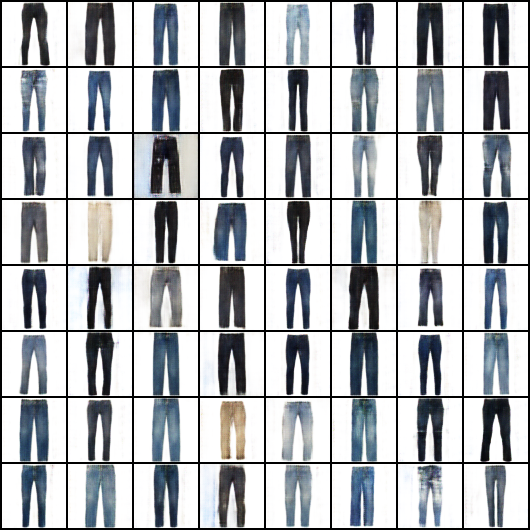

In [46]:
Image('./generated/generated-images-0200.png')

In [47]:

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

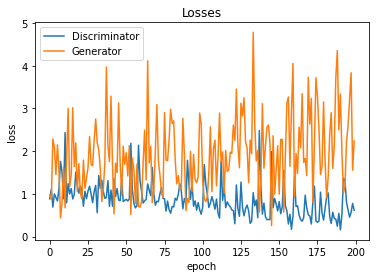

In [48]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

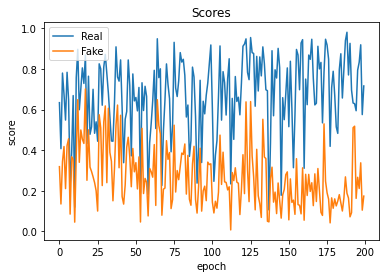

In [49]:

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Saving generated-images-0200.png


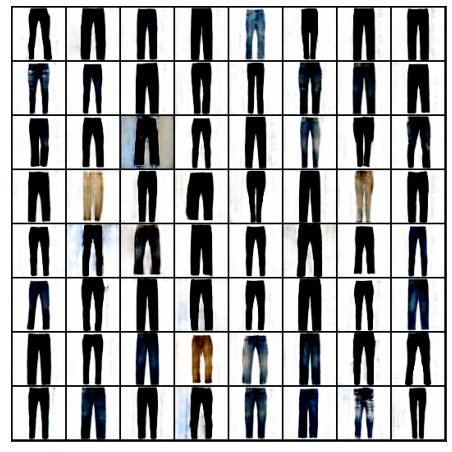

In [51]:
save_samples(200, fixed_latent)